# <center><b> Práctica 3 de Laboratorio 5 </b><br><u> Conteo de Fotones </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [133]:
import pyvisa as visa
# import nidaqmx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

# Formato para los gráficos:
MARKER_FMT = dict(markersize=6, markeredgewidth=0.25, markeredgecolor='k',)
ERROR_FMT = dict(ecolor='k', capsize=2,)

from instrumental import TDS1002B
try:
    rm.close()
except NameError:
    pass
rm = visa.ResourceManager()

instruments = rm.list_resources()
print(instruments)

for inst in instruments:
    if ('C108011::0::INSTR' in inst
        or 'C108013::0::INSTR' in inst
        or 'C065093::0::INSTR' in inst):  # Ojo si nos cambian el osciloscopio
        print('Osciloscopio TDS1002B detectado:',
            f'\nID: {inst}')
        osci = TDS1002B(inst)


('USB0::1689::867::C108011::0::INSTR',)
Osciloscopio TDS1002B detectado: 
ID: USB0::1689::867::C108011::0::INSTR
TEKTRONIX,TDS 1002B,C108011,CF:91.1CT FV:v22.13



In [134]:
def save_osci_data(t, *channels, filename=None):
    if filename is None:
        raise ValueError('Especificar `filename`.')
    osci_data = np.array([t, *channels],)
    np.save(filename, osci_data, )
    return None

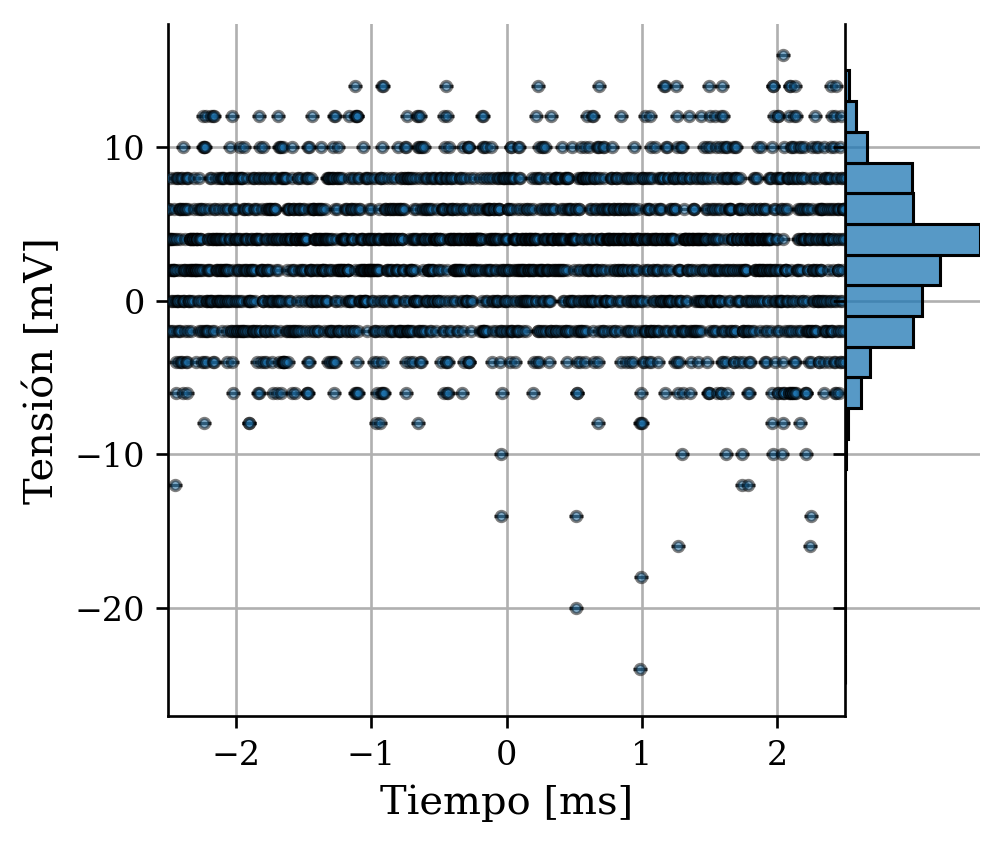

In [138]:
tiempo, channel1 = osci.read_data(1)  # s, V
# tiempo, channel1 = np.load("rudio0.npy")  # s, V
res = 2e-3  # V
vals_unicos = np.unique(channel1)
bins = 1e3*np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # mV
g = sns.JointGrid(x=tiempo*1e3, y=channel1*1e3, height=4, ratio=5, space=0)
# g.plot_joint(plt.errorbar, xerr=np.diff(tiempo).mean(),
#              fmt='.', ms=2, mec="k", mew=0.5, alpha=0.5, ecolor='k', capsize=2, zorder=10)
g.plot_joint(plt.errorbar, yerr=res/2,
             fmt=".", mec="k", ecolor="k", capsize=2, alpha=0.5, zorder=10)
g.ax_marg_x.set_visible(False)
g.plot_marginals(sns.histplot, bins=bins, zorder=10)
g.ax_joint.set_xlabel("Tiempo [ms]")
g.ax_joint.set_ylabel("Tensión [mV]")
g.ax_joint.set_xlim(min(tiempo*1e3), max(tiempo*1e3))
plt.show()

In [139]:
a = {"fotomultiplicador": False, "laser power": False, "laser light": False}
b = {"fotomultiplicador": True, "laser power": False, "laser light": False}
c = {"fotomultiplicador": True, "laser power": True, "laser light": False}
d = {"fotomultiplicador": True, "laser power": True, "laser light": True}

In [43]:
tag = "d"
t_fuente = 990  # V
# t_fuente = 0  # V
for i in range(10):
    tiempo, channel1 = osci.read_data(1)  # s, V
    save_osci_data(tiempo, channel1, filename=f"osci_peaks/ruido_{tag}{t_fuente}{i}.npy")
    time.sleep(5e-3)


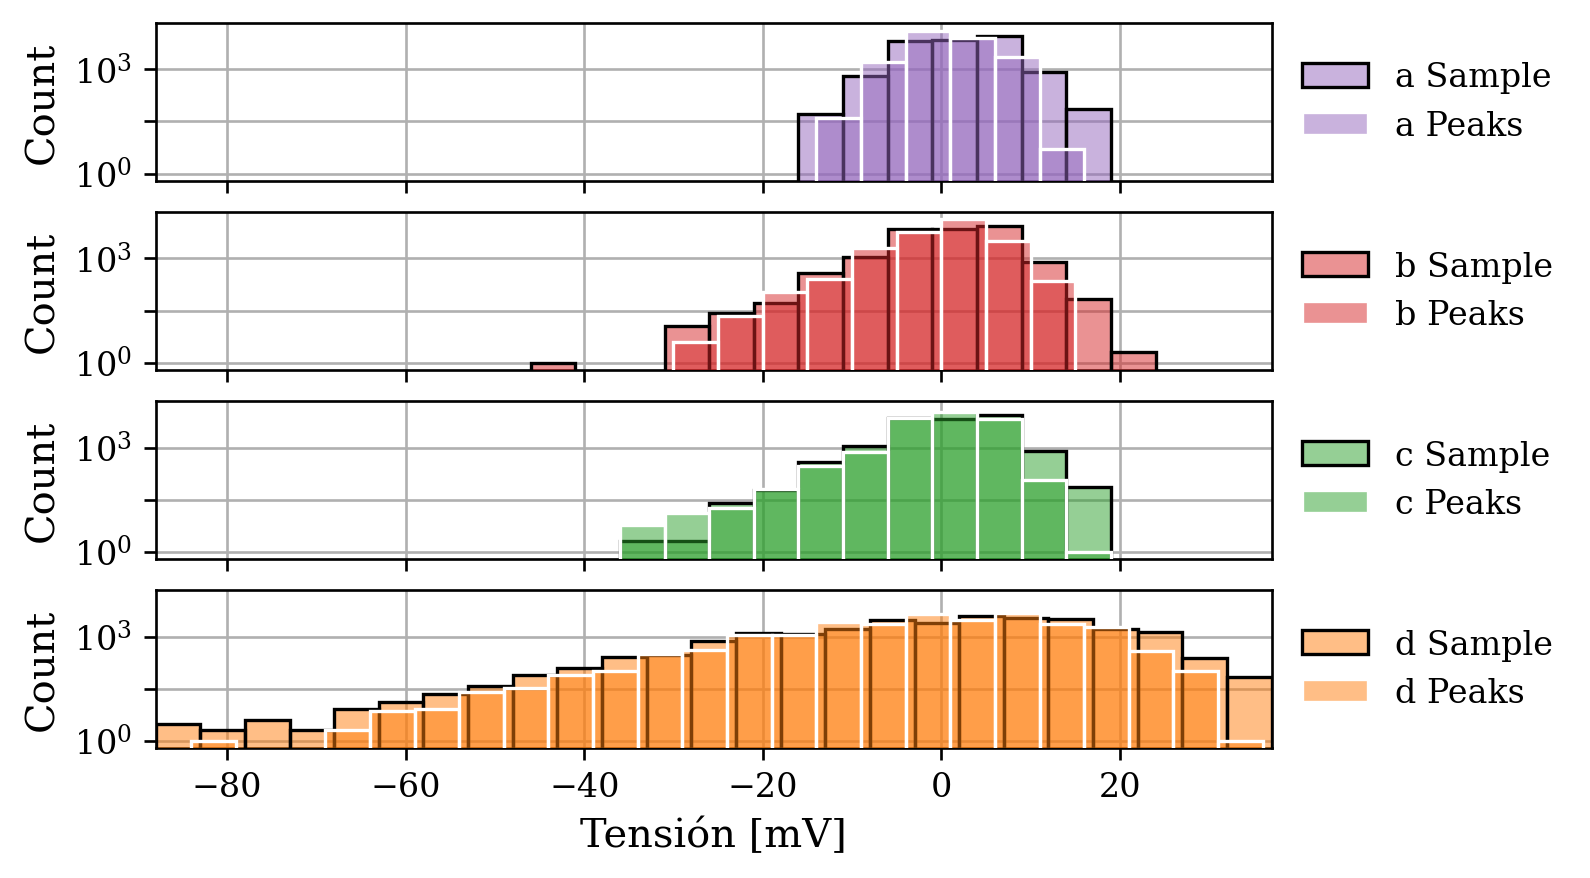

In [52]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
color_id = 4
for config, t_fuente, ax in zip(["a", "b", "c", "d"],
                                [0, 990, 990, 990],
                                axs):
    tiempo = np.zeros(10*2500)
    channel1 = np.zeros_like(tiempo)
    
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"osci_sample/ruido_{config}{t_fuente}{i}.npy")  # s, V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", binwidth=5, zorder=10, edgecolor="k",
                 #element="step", fill=False,
                 alpha=0.5,
                 label=config + " Sample", ax=ax)
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"osci_peaks/ruido_{config}{t_fuente}{i}.npy")  # s, V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", binwidth=5, zorder=10, edgecolor="w",
                 #element="step", fill=False,
                 alpha=0.5,
                 label=config + " Peaks", ax=ax)
    color_id -= 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_yscale("log")
ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

## Barrido Tensión

In [172]:
tag = "c"
t_fuente = [1050, 990, 930,]  # V
# angulo_pol = 230 # para las que se llaman tension_ algo o peaks_algo
angulo_pol = 240  # para peaks240 con escala vertical 100 mV
for i in range(10):
    tiempo, channel1 = osci.read_data(1)  # s, V
    save_osci_data(tiempo, channel1, filename=f"barrido/peaks240_tension_{tag}{t_fuente[2]}{i}.npy")
    time.sleep(5e-3)

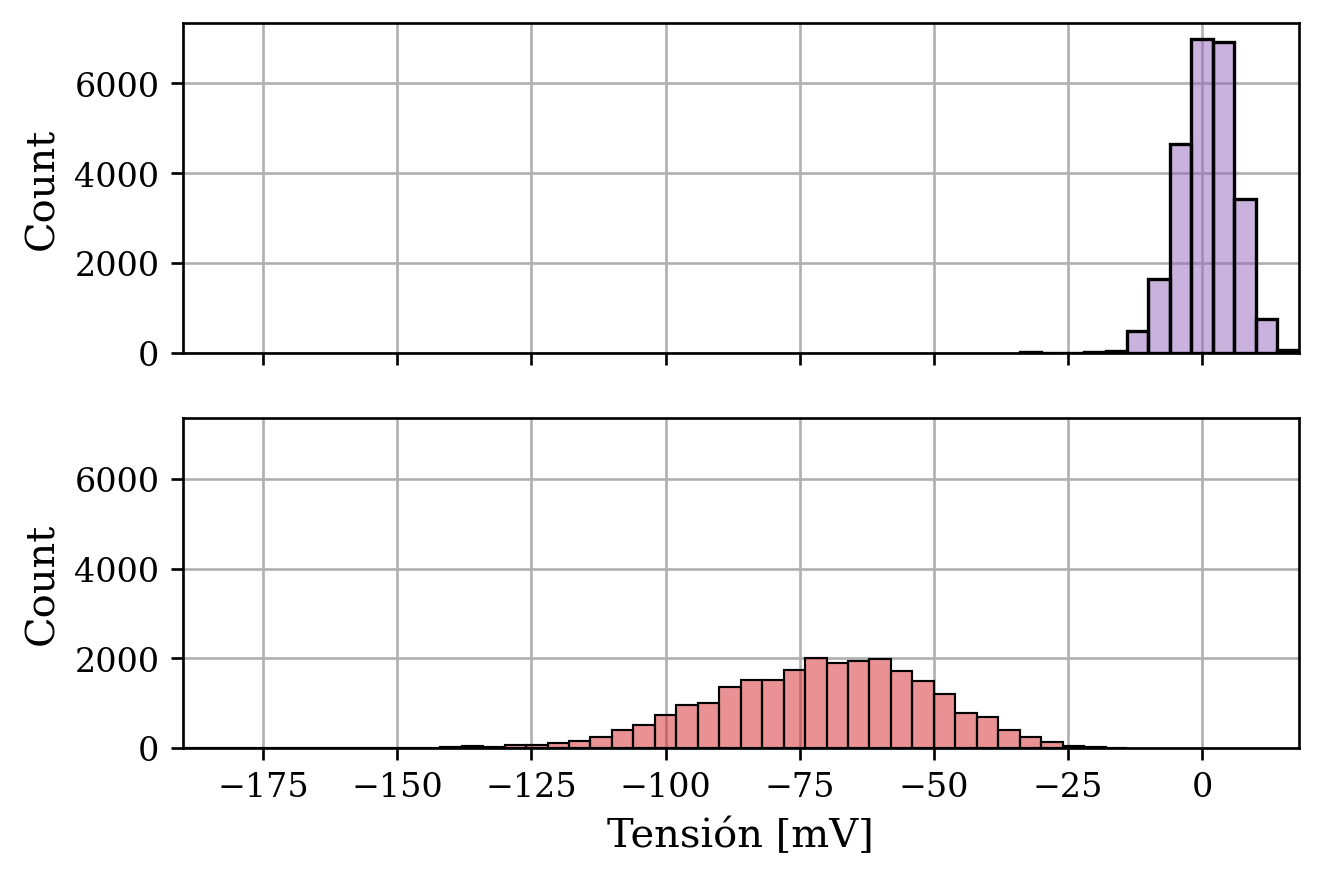

In [173]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
color_id = 4
for config, tension, ax in zip(["c", "d"],
                                [t_fuente[2], t_fuente[2]],
                                axs):
    tiempo = np.zeros(10*2500)
    channel1 = np.zeros_like(tiempo)
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"barrido/peaks240_tension_{config}{tension}{i}.npy")  # s, V
    # res = 2e-3  # Escala en 50 mV
    res = 4e-3  # Escala en 100 mV
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", bins=bins*1e3, zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample", ax=ax)
    color_id -= 1
    # ax.set_yscale("log")
# ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

## Barrido Ángulo Polarizador

In [122]:
tag = "c"
t_fuente = 1050  # V
angulo_pol = [230, 240, 220]
# t_fuente = 0  # V
for i in range(10):
    tiempo, channel1 = osci.read_data(1)  # s, V
    save_osci_data(tiempo, channel1, filename=f"barrido/angulo_{tag}{angulo_pol[-1]}{i}.npy")
    time.sleep(5e-3)

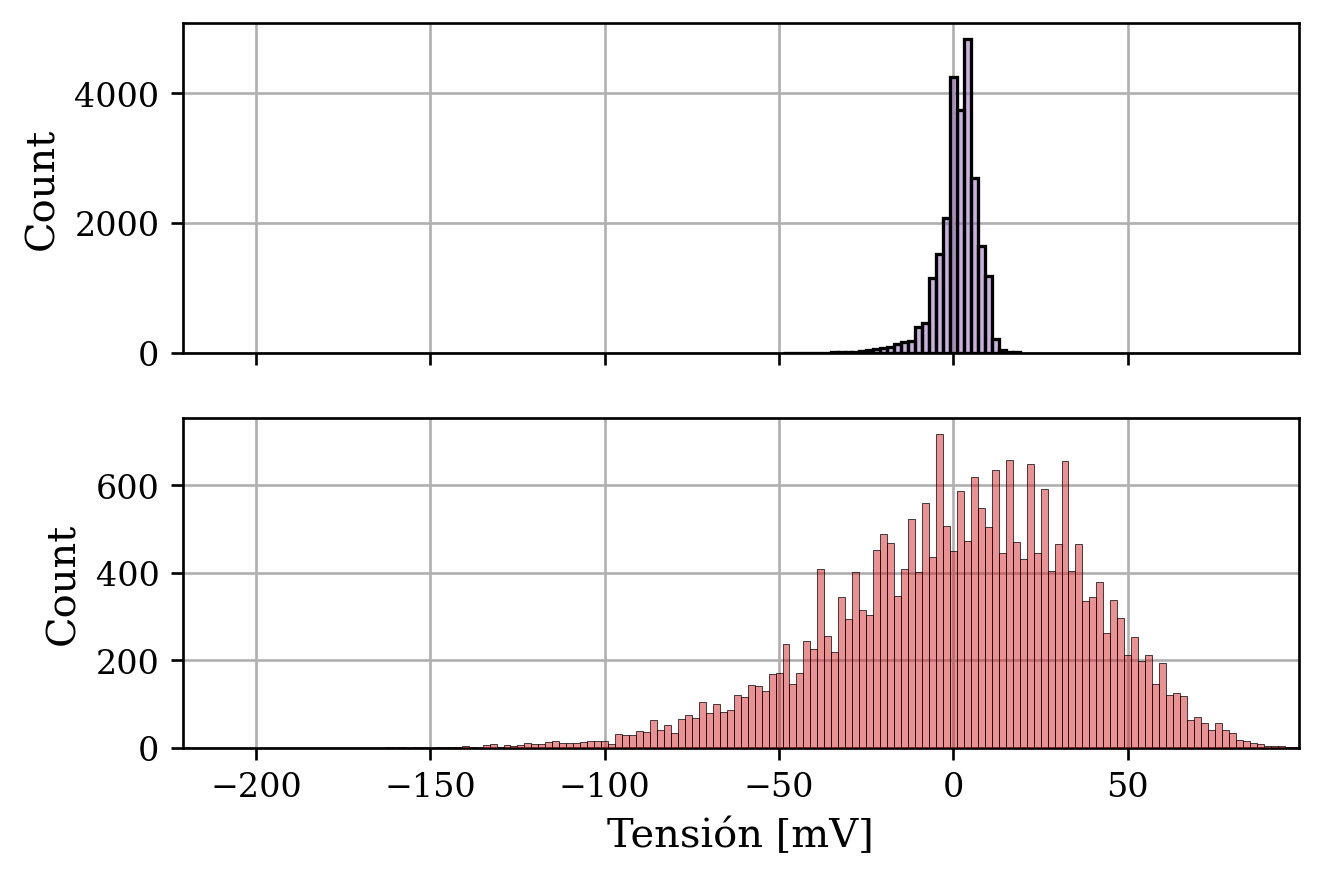

In [129]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)
color_id = 4
for config, ang, ax in zip(["c", "d"],
                            [240, 240],
                            axs):
    tiempo = np.zeros(10*2500)
    channel1 = np.zeros_like(tiempo)
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"barrido/angulo_{config}{ang}{i}.npy")  # s, V
    res = 2e-3
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", bins=bins*1e3, zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample", ax=ax)
    color_id -= 1
    # ax.set_yscale("log")
# ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()